## Initialization

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import os, sys
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## EDA

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.duplicated().sum()

0

<AxesSubplot:xlabel='real_age', ylabel='Count'>

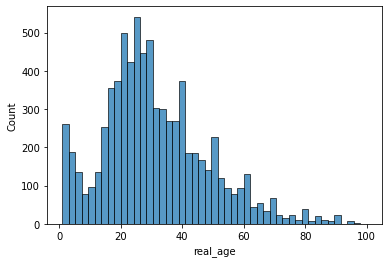

In [7]:
sns.histplot(labels['real_age'])

In [8]:
def plot_images(df, path, num=5, img_datagen=None, is_generator=True):
    plt.figure(figsize=(10, 10))
    if is_generator:
        faces = df['file_name'].sample(n=num)
    else:
        faces, x = img_datagen
        faces = faces[:num]
    for idx, file in enumerate(faces):
        plt.subplot(2, 5, idx+1)
        if is_generator:
            img = Image.open(os.path.join(path, file))
            plt.imshow(np.array(img, dtype=np.uint8))
        else:
            img = file
            plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

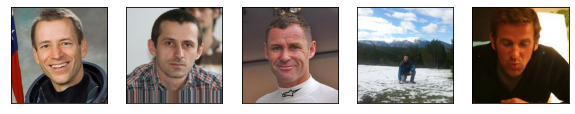

In [9]:
plot_images(labels, r'/datasets/faces/final_files/')

### Findings

In [10]:
datagen = ImageDataGenerator(rescale=1/255.,
                  horizontal_flip=True,
                  zoom_range=0.2,
                  width_shift_range=.2)

In [11]:
img_datagen = datagen.flow_from_dataframe(labels, 
                            x_col='file_name',
                            y_col='real_age',
                            directory=r'/datasets/faces/final_files/',
                            target_size=(100, 100),
                            batch_size=32,
                            class_mode='raw')
len(img_datagen)

Found 7591 validated image filenames.


238

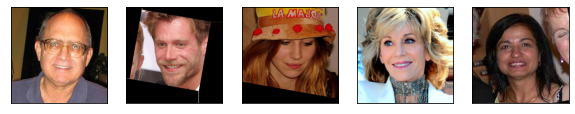

In [12]:
plot_images(labels, r'/datasets/faces/final_files/', is_generator=True, img_datagen=next(img_datagen))

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [13]:
df_face = pd.read_csv('/datasets/faces/labels.csv')

In [14]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1/255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_face,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345,
        )

    return train_datagen_flow

In [15]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=df_face,
    directory='/datasets/faces/final_files/',
     x_col='file_name',
    y_col='real_age',
    target_size=(150, 150),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345,
    )

    return test_datagen_flow

In [16]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [17]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [18]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as a Markdown cell here.

Found 6073 validated image filenames.\
Found 1897 validated image filenames.\
Train for 380 steps, validate for 119 steps\
Epoch 1/20\
2023-08-29 00:35:44.930882: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10\
2023-08-29 00:35:45.233508: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7\
2023-08-29 00:35:47.051866: W tensorflow/core/common_runtime/bfc_allocator.cc:309] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.\
380/380 - 82s - loss: 235.2907 - mae: 11.3991 - val_loss: 742.4410 - val_mae: 22.2266\
Epoch 2/20\
380/380 - 75s - loss: 125.2115 - mae: 8.5257 - val_loss: 185.0493 - val_mae: 9.9177\
Epoch 3/20\
380/380 - 75s - loss: 101.8836 - mae: 7.7027 - val_loss: 77.6524 - val_mae: 6.6624\
Epoch 4/20\
380/380 - 74s - loss: 90.5591 - mae: 7.2117 - val_loss: 90.7958 - val_mae: 7.2009\
Epoch 5/20\
380/380 - 73s - loss: 83.3613 - mae: 6.9215 - val_loss: 83.1942 - val_mae: 6.8101\
Epoch 6/20\
380/380 - 71s - loss: 74.6405 - mae: 6.6126 - val_loss: 149.1613 - val_mae: 8.9051\
Epoch 7/20\
380/380 - 71s - loss: 68.0968 - mae: 6.3061 - val_loss: 94.7763 - val_mae: 7.4266\
Epoch 8/20\
380/380 - 72s - loss: 62.5499 - mae: 6.0499 - val_loss: 107.6794 - val_mae: 7.6112\
Epoch 9/20\
380/380 - 77s - loss: 57.1083 - mae: 5.7819 - val_loss: 77.6739 - val_mae: 6.6111\
Epoch 10/20\
380/380 - 76s - loss: 52.0824 - mae: 5.5108 - val_loss: 71.7303 - val_mae: 6.1787\
Epoch 11/20\
380/380 - 76s - loss: 47.3678 - mae: 5.3004 - val_loss: 93.8643 - val_mae: 6.9866\
Epoch 12/20\
380/380 - 75s - loss: 51.5182 - mae: 5.4361 - val_loss: 70.2384 - val_mae: 6.3034\
Epoch 13/20\
380/380 - 76s - loss: 44.8030 - mae: 5.1084 - val_loss: 66.9168 - val_mae: 6.1505\
Epoch 14/20\
380/380 - 75s - loss: 39.4888 - mae: 4.8288 - val_loss: 119.7559 - val_mae: 8.6724\
Epoch 15/20\
380/380 - 75s - loss: 39.9989 - mae: 4.8405 - val_loss: 63.2594 - val_mae: 5.9195\
Epoch 16/20\
380/380 - 73s - loss: 37.4263 - mae: 4.7137 - val_loss: 73.4622 - val_mae: 6.4329\
Epoch 17/20\
380/380 - 69s - loss: 32.9546 - mae: 4.4004 - val_loss: 67.5431 - val_mae: 6.1338\
Epoch 18/20\
380/380 - 69s - loss: 33.5456 - mae: 4.4777 - val_loss: 70.8238 - val_mae: 6.1888\
Epoch 19/20\
380/380 - 69s - loss: 28.8019 - mae: 4.1705 - val_loss: 66.2464 - val_mae: 5.9478\
Epoch 20/20\
380/380 - 70s - loss: 27.7093 - mae: 4.0401 - val_loss: 74.1642 - val_mae: 6.1754\
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 74.1642 - mae: 6.1754

## Conclusions

# Checklist

- [ ]  Notebook was opened
- [ ]  The code is error free
- [ ]  The cells with code have been arranged by order of execution
- [ ]  The exploratory data analysis has been performed
- [ ]  The results of the exploratory data analysis are presented in the final notebook
- [ ]  The model's MAE score is not higher than 8
- [ ]  The model training code has been copied to the final notebook
- [ ]  The model training output has been copied to the final notebook
- [ ]  The findings have been provided based on the results of the model training